# Setup

## Imports

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from matplotlib.pyplot import cm
from scipy.fftpack import fft

import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# from fdasrsf import fPCA, time_warping, fdawarp, fdahpcafd
# Article about fPCA here: https://towardsdatascience.com/beyond-classic-pca-functional-principal-components-analysis-fpca-applied-to-time-series-with-python-914c058f47a0

## Constants

In [257]:
sub_dirs = ['8hz_20trials/','9hz_20trials/','10hz_20trials/',
            '11hz_10trials_run1/','11hz_10trials_run2/',
            '12hz_10trials_run1/','12hz_10trials_run2/',
            '12.6hz_10trials_run1/','12.6hz_10trials_run2/',
            '13hz_10trials_run1/','13hz_10trials_run2/',
            '14hz_10trials_run1/','14hz_10trials_run2/',
            '15hz_10trials_run1/','15hz_10trials_run2/']

num_targets = 36
sampling_frequency = 300
isi_duration = 0.750  # s
stimulus_duration = 5.000 # s
num_trial_per_target = 20
channels = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3']
num_channels = len(channels)
timepoints_stimulus_duration = int(stimulus_duration * sampling_frequency)  # 1500
timepoints_isi = int(sampling_frequency * isi_duration)
timepoints_per_trial = int((isi_duration + stimulus_duration) * sampling_frequency)

# Data

In [258]:
def load_data_temp_function(eeg, meta, classes):
    """
    Return
        (
    """
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:timepoints_per_trial].T for t in times])[:,:,timepoints_isi:]
    eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

Aggregate the different recording (trials, single_recording_target, channels, timepoints) to (trials, num_targets, channels, timepoints)
Assuming each recording comes with 4 targets 

In [259]:
eeg_all = np.zeros((num_trial_per_target, num_targets, num_channels, timepoints_stimulus_duration))
trial_all = []  # (num_targets, 1 + 1), freq and phase
recording_count = 0
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)  # (4, 2), 4 targets, each target has a freq and a phase
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path2 + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path2 + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    trial_all.append(classes.tolist())
    eeg_all[:, recording_count:recording_count + 4] = eeg
    recording_count += 4
trial_all = np.array(trial_all).reshape([-1, 2])  

Create a lookup table from (freq, phase) to 0, 1, ..., num_targets - 1

In [260]:
target_idx_tab = {}
target_idx_tab = {(freq, phase): i for i, (freq, phase) in enumerate(trial_all)}
target_idx_tab

{(8.0, 0.0): 0,
 (8.0, 0.5): 1,
 (8.0, 1.0): 2,
 (8.0, 1.5): 3,
 (9.0, 0.0): 4,
 (9.0, 0.5): 5,
 (9.0, 1.0): 6,
 (9.0, 1.5): 7,
 (10.0, 0.0): 8,
 (10.0, 0.5): 9,
 (10.0, 1.0): 10,
 (10.0, 1.5): 11,
 (11.0, 0.0): 12,
 (11.0, 0.5): 13,
 (11.0, 1.0): 14,
 (11.0, 1.5): 15,
 (12.0, 0.0): 16,
 (12.0, 0.5): 17,
 (12.0, 1.0): 18,
 (12.0, 1.5): 19,
 (12.6, 0.25): 20,
 (12.6, 0.75): 21,
 (12.6, 1.25): 22,
 (12.6, 1.75): 23,
 (13.0, 0.0): 24,
 (13.0, 0.5): 25,
 (13.0, 1.0): 26,
 (13.0, 1.5): 27,
 (14.0, 0.0): 28,
 (14.0, 0.5): 29,
 (14.0, 1.0): 30,
 (14.0, 1.5): 31,
 (15.0, 0.25): 32,
 (15.0, 0.75): 33,
 (15.0, 1.25): 34,
 (15.0, 1.75): 35}

## PCA Analysis
We'll use PCA to see the variance of each recording channels and seek to reduce the number of recording channels
Refer to https://medium.com/@ansjin/dimensionality-reduction-using-pca-on-multivariate-timeseries-data-b5cc07238dc4 for more details

Before applying PCA, we first have to concatenate all the trials and targets and swap channel and timepoints such that the final dimension is (timepoints * num_targets * trials, channels)

In [261]:
def highlight_abs_max(s):
    is_max = abs(s) == abs(s).max()
    return ['background-color: green' if v else '' for v in is_max]
def highlight_abs_min(s):
    is_min = abs(s) == abs(s).min()
    return ['background-color: red' if v else '' for v in is_min]
# df.T.style.apply(highlight_abs_max).apply(highlight_abs_min)

In [262]:
eeg_all_flatten = eeg_all.transpose(0, 1, 3, 2)
eeg_all_flatten = eeg_all_flatten.reshape((-1, num_channels))
assert eeg_all_flatten.shape == (num_targets * timepoints_stimulus_duration * num_trial_per_target, num_channels)

In [263]:
pca = PCA(n_components=num_channels)
eeg_all_pca = pca.fit_transform(eeg_all_flatten)
n_pc = eeg_all_pca.shape[-1]
pc_channels = [f'PC{i}' for i in range(n_pc)]

# reshape eeg_all_pca to ((num_trial_per_target, num_targets, num_pc, timepoints_stimulus_duration)
eeg_all_pca = eeg_all_pca.reshape((num_trial_per_target, num_targets, timepoints_stimulus_duration, n_pc))
eeg_all_pca = eeg_all_pca.transpose(0, 1, 3, 2)
assert eeg_all_pca.shape == (num_trial_per_target, num_targets, n_pc, timepoints_stimulus_duration)

Determine most salient channels based on how much the channels explains each PC

In [264]:
df = pd.DataFrame(pca.components_, columns=channels)
df.index = pc_channels
df.T.style.apply(highlight_abs_max)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
Pz,0.557721,-0.107301,-0.500188,-0.347649,0.288800,-0.397921,-0.254245
F4,0.159199,-0.403695,0.329867,0.387409,0.006609,-0.648560,0.363476
C4,0.231443,-0.355958,0.012960,0.513357,-0.239999,0.211718,-0.673499
P4,0.403689,-0.246262,-0.357462,0.198585,-0.024779,0.516555,0.584579
P3,0.576243,0.701982,0.336767,0.240952,0.056250,0.022657,0.004227
C3,0.291381,-0.123570,0.250410,-0.509858,-0.758084,-0.009061,0.048925
F3,0.173535,-0.360717,0.580462,-0.328739,0.529606,0.329819,-0.074166


[0.70664017 0.11646218 0.08316885 0.04275267 0.02502631 0.01670521
 0.00924462]
[0.70664017 0.82310235 0.9062712  0.94902387 0.97405017 0.99075538
 1.        ]


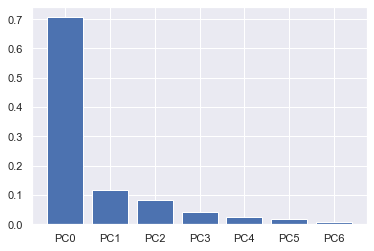

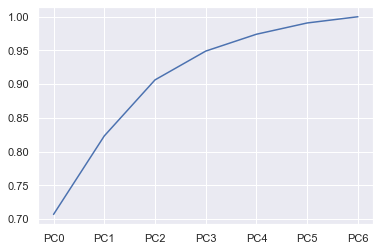

In [265]:
plt.figure()
plt.bar(pc_channels, pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pc_channels, np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))

### Fit based on MLE

In [266]:
# scaler = StandardScaler()
# eeg_all_flatten = scaler.fit_transform(eeg_all_flatten)

pca = PCA(n_components='mle')
eeg_all_pca = pca.fit_transform(eeg_all_flatten)
n_pc = eeg_all_pca.shape[-1]
pc_channels = [f'PC{i}' for i in range(n_pc)]

# reshape eeg_all_pca to ((num_trial_per_target, num_targets, num_pc, timepoints_stimulus_duration)
eeg_all_pca = eeg_all_pca.reshape((num_trial_per_target, num_targets, timepoints_stimulus_duration, n_pc))
eeg_all_pca = eeg_all_pca.transpose(0, 1, 3, 2)
assert eeg_all_pca.shape == (num_trial_per_target, num_targets, n_pc, timepoints_stimulus_duration)

Determine most salient channels based on how much the channels explains each PC

In [267]:
df = pd.DataFrame(pca.components_, columns=channels)
df.index = pc_channels
df.T.style.apply(highlight_abs_max)

,PC0,PC1,PC2,PC3,PC4,PC5
Pz,0.557721,-0.107301,-0.500188,-0.347649,0.288800,-0.397921
F4,0.159199,-0.403695,0.329867,0.387409,0.006609,-0.648560
C4,0.231443,-0.355958,0.012960,0.513357,-0.239999,0.211718
P4,0.403689,-0.246262,-0.357462,0.198585,-0.024779,0.516555
P3,0.576243,0.701982,0.336767,0.240952,0.056250,0.022657
C3,0.291381,-0.123570,0.250410,-0.509858,-0.758084,-0.009061
F3,0.173535,-0.360717,0.580462,-0.328739,0.529606,0.329819


[0.70664017 0.11646218 0.08316885 0.04275267 0.02502631 0.01670521]
[0.70664017 0.82310235 0.9062712  0.94902387 0.97405017 0.99075538]


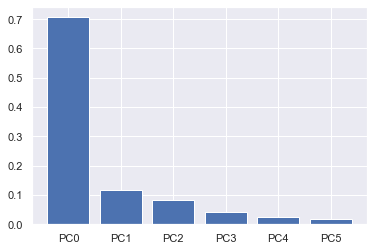

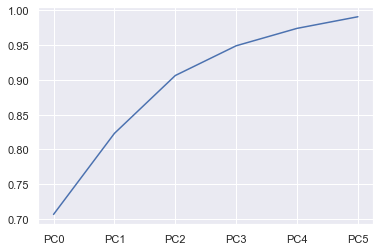

In [268]:
plt.figure()
plt.bar(pc_channels, pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pc_channels, np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))

Seems like most channels are contributing 

### Compare PCA PSD v.s. Original PSD

Original

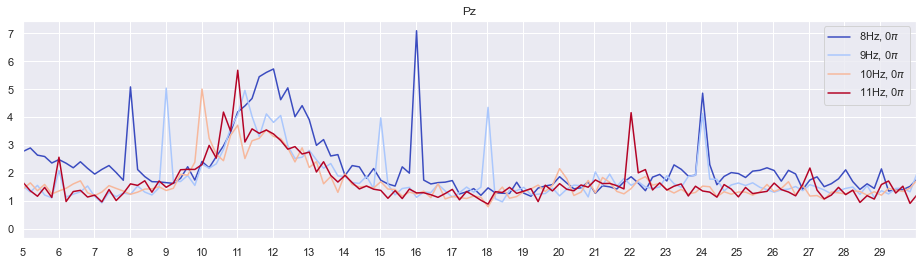

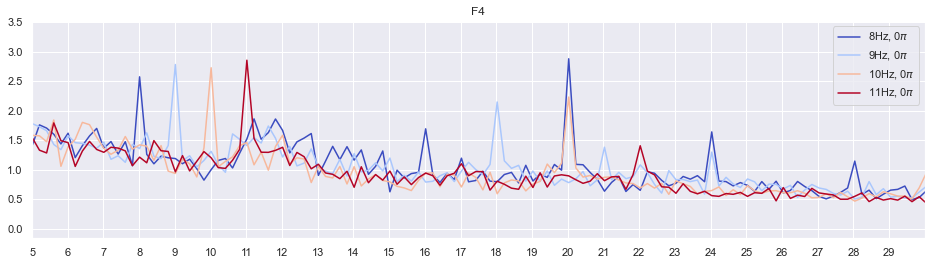

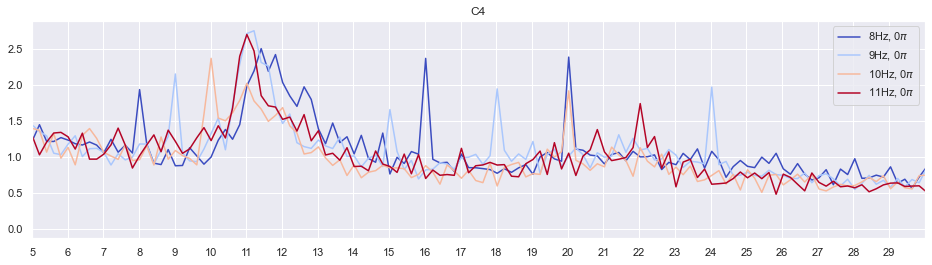

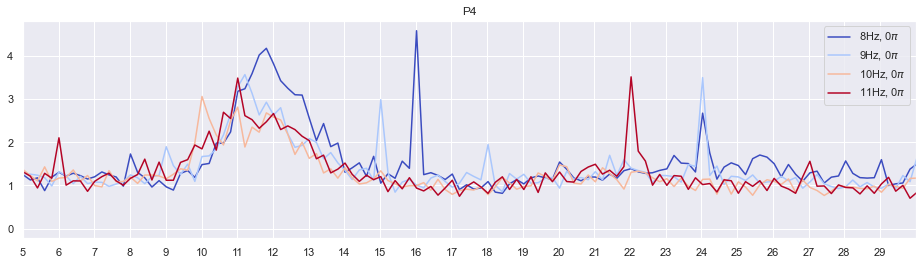

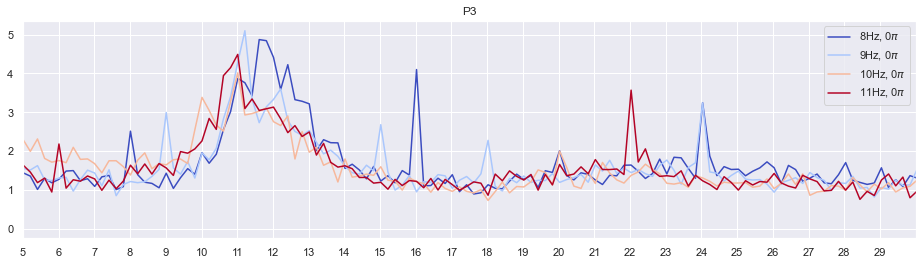

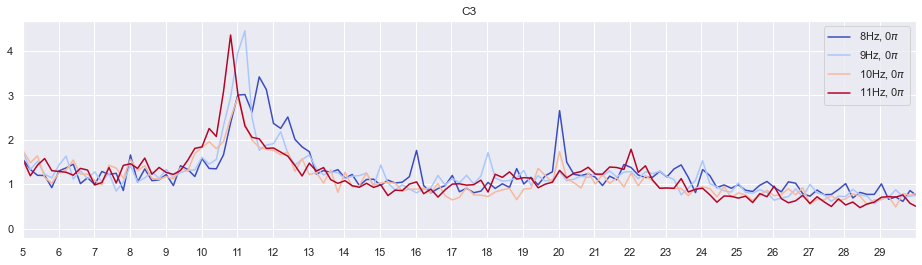

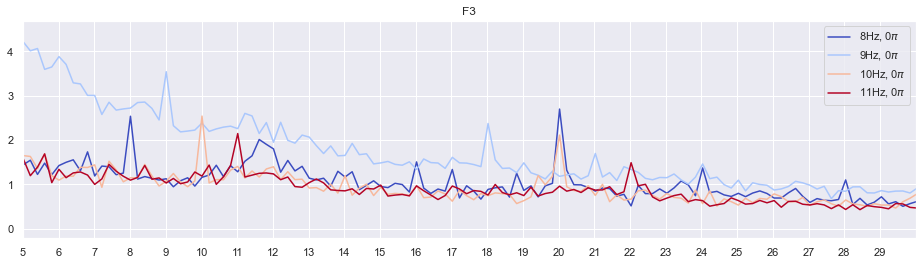

In [269]:
freqs = np.linspace(0.0, sampling_frequency / 2, timepoints_stimulus_duration // 2)
psd = 2/(timepoints_stimulus_duration / 2)*np.abs(fft(eeg_all)[:,:,:,:timepoints_stimulus_duration // 2])
psd = psd.mean(axis=0) # take the mean psd across sessions
# visualize some of the targets on frequency domain
target_interest = [(8, 0), (9, 0), (10, 0), (11, 0)]
channel_interest = channels
for channel in channel_interest:
    plt.figure(figsize=(16, 4))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    colors=cm.coolwarm(np.linspace(0,1, len(target_interest)))
    for i, (freq, phase) in enumerate(target_interest):
        sns.lineplot(x=freqs, y=psd[target_idx_tab[(freq, phase)], channels.index(channel),:], ax=ax, label=f'{freq}Hz, {phase}$\pi$', color=colors[i])
    plt.title(channel)
    plt.xticks(range(5,30));

PCA

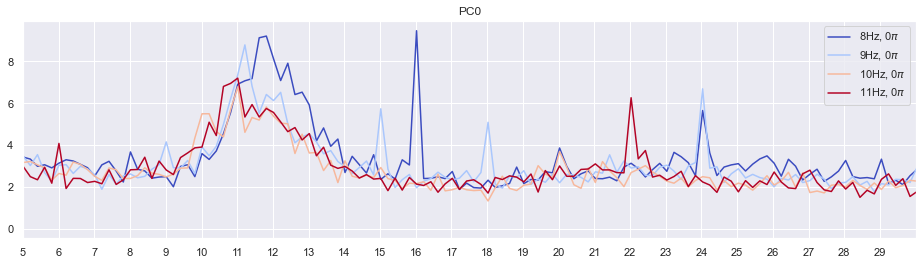

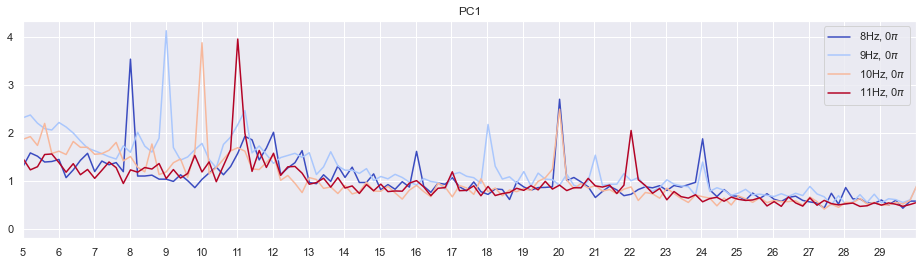

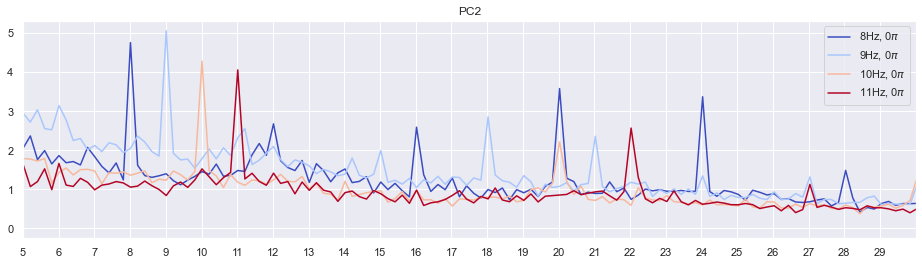

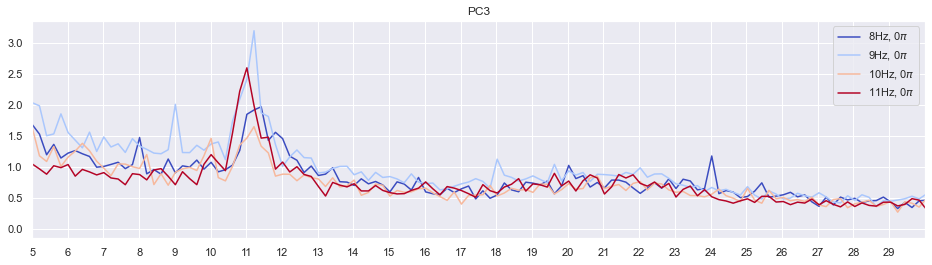

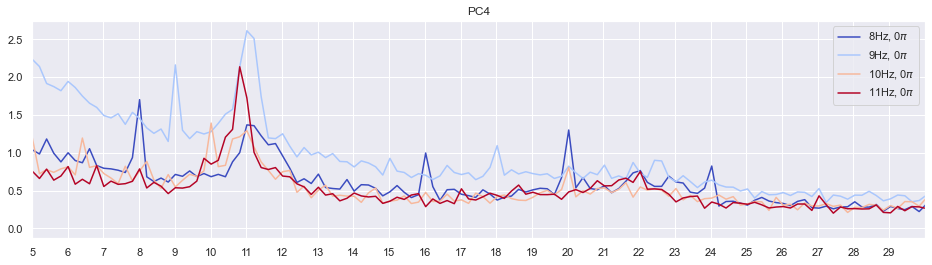

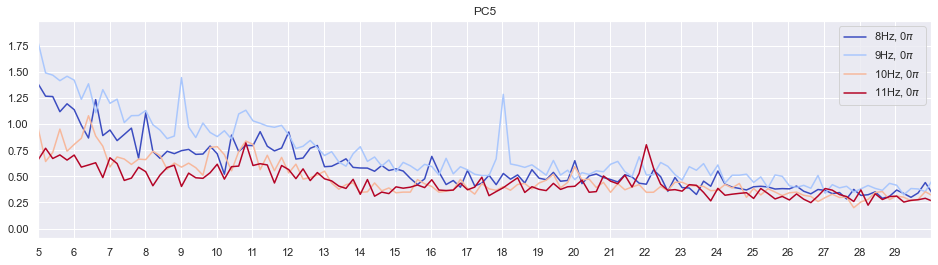

In [270]:
freqs = np.linspace(0.0, sampling_frequency / 2, timepoints_stimulus_duration // 2)
psd = 2/(timepoints_stimulus_duration / 2)*np.abs(fft(eeg_all_pca)[:,:,:,:timepoints_stimulus_duration // 2])
psd = psd.mean(axis=0) # take the mean psd across sessions
# visualize some of the targets on frequency domain
target_interest = [(8, 0), (9, 0), (10, 0), (11, 0)]
channel_interest = pc_channels
for channel in channel_interest:
    plt.figure(figsize=(16, 4))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    colors=cm.coolwarm(np.linspace(0,1, len(target_interest)))
    for i, (freq, phase) in enumerate(target_interest):
        sns.lineplot(x=freqs, y=psd[target_idx_tab[(freq, phase)], pc_channels.index(channel),:], ax=ax, label=f'{freq}Hz, {phase}$\pi$', color=colors[i])
    plt.title(channel)
    plt.xticks(range(5,30));

# Models